# Bói Giá Tiền Ảo với Deep Learning :)

Tutorial này hướng dẫn cách dùng Deep Learning model (RNN - LSTM) để dự đoán giá của tiền ảo.

Warning: Mục đích của bài này là để chúng ta học về AI-Deep Learning, khuyến cáo không nên dùng để đầu cơ :). 
(I'm not resposibility for any loss if you use this for spetaculating)

## Data

Chúng ta sẽ kết hợp nhiều loại tiền ảo trong một model. Nơi để lấy dữ liệu phù hợp nhất là [coinmarketcap.com](https://coinmarketcap.com/). Trong tutorial này chúng ta sẽ lấy dữ liệu của hai đồng có dung lượng thị trường lớn nhất là Bitcoin và Ether.

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import datetime
import numpy as np
import bs4
%matplotlib inline
plt.style.use(u'ggplot')
import seaborn as sns

In [2]:
# Lấy dữ liệu của Bitcoin từ 2016 đến nay
btc_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]

In [4]:
btc_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,"Feb 09, 2018",8271.84,8736.98,7884.71,8736.98,6784820000,139412000000
1,"Feb 08, 2018",7637.86,8558.77,7637.86,8265.59,9346750000,128714000000
2,"Feb 07, 2018",7755.49,8509.11,7236.79,7621.30,9169280000,130683000000
3,"Feb 06, 2018",7051.75,7850.70,6048.26,7754.00,13999800000,118810000000
4,"Feb 05, 2018",8270.54,8364.84,6756.68,6955.27,9285290000,139325000000


In [13]:
btc_market_info = btc_market_info.assign(Date=pd.to_datetime(btc_market_info['Date']))
btc_market_info.loc[btc_market_info['Volume']=="-", 'Volume']=0
btc_market_info['Volume'] = btc_market_info['Volume'].astype('int64')

In [7]:
btc_market_info.tail()

,Date,Open,High,Low,Close,Volume,Market Cap
1740,2013-05-02,116.38,125.60,92.28,105.21,0,1292190000
1741,2013-05-01,139.00,139.89,107.72,116.99,0,1542820000
1742,2013-04-30,144.00,146.93,134.05,139.00,0,1597780000
1743,2013-04-29,134.44,147.49,134.00,144.54,0,1491160000
1744,2013-04-28,135.30,135.98,132.10,134.21,0,1500520000


In [8]:
btc_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-02-05,8270.54,8364.84,6756.68,6955.27,9285290000,139325000000
1,2018-02-04,9175.70,9334.87,8031.22,8277.01,7073550000,154553000000
2,2018-02-03,8852.12,9430.75,8251.63,9174.91,7263790000,149085000000
3,2018-02-02,9142.28,9142.28,7796.49,8830.75,12726900000,153953000000
4,2018-02-01,10237.30,10288.80,8812.28,9170.54,9959400000,172372000000


In [14]:
btc_market_info.columns  = [btc_market_info.columns[0]] + ['btc_' + i for i in btc_market_info.columns[1:]]

In [75]:
btc_market_info.tail()

,Date,btc_Open,btc_High,btc_Low,btc_Close,btc_Volume,btc_Market Cap
1740,2013-05-02,116.38,125.60,92.28,105.21,0,1292190000
1741,2013-05-01,139.00,139.89,107.72,116.99,0,1542820000
1742,2013-04-30,144.00,146.93,134.05,139.00,0,1597780000
1743,2013-04-29,134.44,147.49,134.00,144.54,0,1491160000
1744,2013-04-28,135.30,135.98,132.10,134.21,0,1500520000


Chúng ta có thể vẽ đồ thị giá và volume của đồng này để nhìn rõ hơn về trend.

In [66]:
def crypto_chart(crypto_info, crypto_name):
    fig = plt.figure(figsize=(10,8))
    ax1, ax2 = fig.subplots(2,1, gridspec_kw= {'height_ratios':[2, 1]})
    ax1.set_ylabel('Closing Price ($)',fontsize=12)
    ax2.set_ylabel('Volume ($ bn)',fontsize=12)
    ax2.set_yticks([int('%d000000000'%i) for i in range(30)])
    ax2.set_yticklabels(range(30))
    ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
    ax1.set_xticklabels('')
    ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
    ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
    ax1.plot(crypto_info['Date'].astype(datetime.datetime),crypto_info[crypto_name + '_Open'])
    ax2.bar(crypto_info['Date'].astype(datetime.datetime).values, crypto_info[crypto_name+'_Volume'].values)
    fig.suptitle(crypto_name+ " Chart", fontsize=18, y = 1.03)
    fig.tight_layout()
    plt.show()

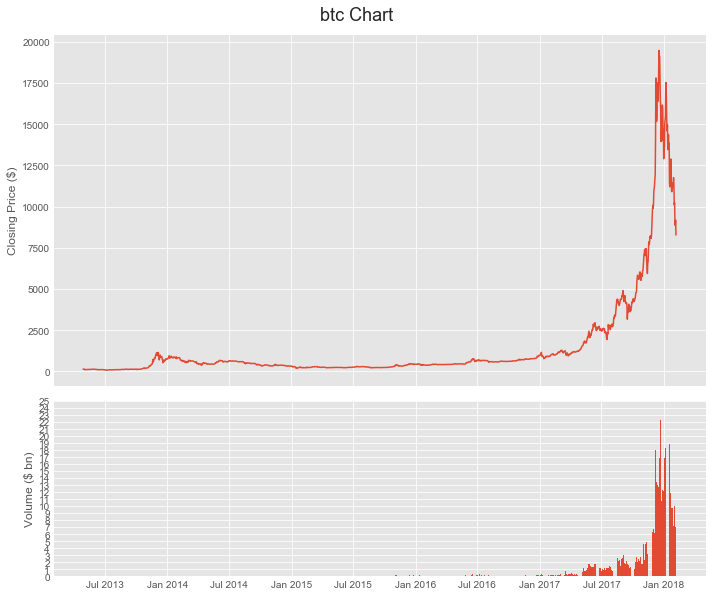

In [67]:
crypto_chart(btc_market_info, 'btc')

Chúng ta có thể lấy dữ liệu của đồng tiền khác một cách tương tự. Ví dụ ta lấy thêm dữ liệu của đồng ETH

In [71]:
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
eth_market_info['Volume'] = eth_market_info['Volume'].astype('int64')
eth_market_info.columns  = [eth_market_info.columns[0]] + ['eth_' + i for i in eth_market_info.columns[1:]]
eth_market_info.head()

,Date,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap
0,2018-02-06,707.74,796.44,574.42,793.12,6518270000,68958700000
1,2018-02-05,834.96,856.65,644.60,697.95,4269530000,81337400000
2,2018-02-04,964.67,969.03,805.06,834.68,2997090000,93953400000
3,2018-02-03,919.21,991.94,847.69,964.02,3243480000,89507600000
4,2018-02-02,1035.77,1035.77,757.98,915.78,6713290000,100836000000


In [74]:
eth_market_info.tail()

,Date,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap
910,2015-08-11,0.708087,1.130000,0.663235,1.070000,1463100,42796500
911,2015-08-10,0.713989,0.729854,0.636546,0.708448,405283,43130000
912,2015-08-09,0.706136,0.879810,0.629191,0.701897,532170,42637600
913,2015-08-08,2.790000,2.800000,0.714725,0.753325,674188,167911000
914,2015-08-07,2.830000,3.540000,2.520000,2.770000,164329,-


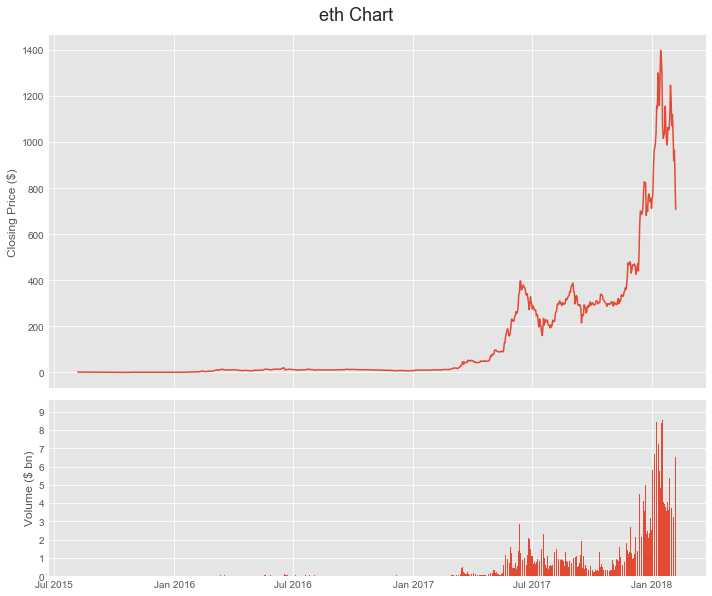

In [72]:
crypto_chart(eth_market_info, 'eth')

Gộp dữ liệu của 2 coins trên thành một dữ liệu:

In [79]:
market_info = pd.merge(btc_market_info,eth_market_info, on=['Date'])
market_info = market_info[market_info['Date']>='2015-08-08']
for coins in ['btc_', 'eth_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
market_info.head()

,Date,btc_Open,btc_High,btc_Low,btc_Close,btc_Volume,btc_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,btc_day_diff,eth_day_diff
0,2018-02-05,8270.54,8364.84,6756.68,6955.27,9285290000,139325000000,834.96,856.65,644.60,697.95,4269530000,81337400000,-0.159031,-0.164092
1,2018-02-04,9175.70,9334.87,8031.22,8277.01,7073550000,154553000000,964.67,969.03,805.06,834.68,2997090000,93953400000,-0.097942,-0.134751
2,2018-02-03,8852.12,9430.75,8251.63,9174.91,7263790000,149085000000,919.21,991.94,847.69,964.02,3243480000,89507600000,0.036465,0.048748
3,2018-02-02,9142.28,9142.28,7796.49,8830.75,12726900000,153953000000,1035.77,1035.77,757.98,915.78,6713290000,100836000000,-0.034076,-0.115846
4,2018-02-01,10237.30,10288.80,8812.28,9170.54,9959400000,172372000000,1119.37,1161.35,984.82,1036.79,5261680000,108952000000,-0.104203,-0.073774


In [80]:
market_info.tail()

,Date,btc_Open,btc_High,btc_Low,btc_Close,btc_Volume,btc_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,btc_day_diff,eth_day_diff
908,2015-08-12,270.60,270.67,265.47,266.38,26815400,3920210000,1.060000,1.290000,0.883608,1.220000,2150620,64018400,-0.015595,0.150943
909,2015-08-11,264.34,270.39,264.09,270.39,25433900,3828500000,0.708087,1.130000,0.663235,1.070000,1463100,42796500,0.022887,0.511114
910,2015-08-10,265.48,267.03,262.60,264.47,20979400,3843850000,0.713989,0.729854,0.636546,0.708448,405283,43130000,-0.003804,-0.007761
911,2015-08-09,261.12,267.00,260.47,265.08,23789600,3779770000,0.706136,0.879810,0.629191,0.701897,532170,42637600,0.015165,-0.006003
912,2015-08-08,279.74,279.93,260.71,261.00,58533000,4048270000,2.790000,2.800000,0.714725,0.753325,674188,167911000,-0.066991,-0.729991


## Train and Test Data

Chia dữ liệu thành tập train và tập test. Dữ liệu chúng ta có la dữ liệu kiểu "time series", chúng ta có thể chia dữ liệu bằng cách chọn một ngày (cut-off date) để chia dữ liệu thành 2 phân, dữ liệu trươc ngày đó sẽ được dùng để train model dữ liệu sau ngày đó dùng để test. Trong tutorial này ta chọn cut-off date là 2017-08-08.

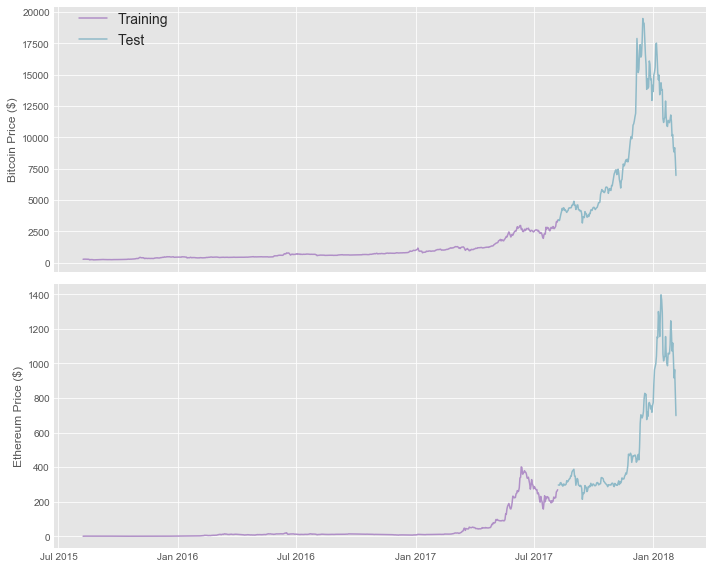

In [86]:
split_date = '2017-08-08'
fig = plt.figure(figsize=(10,8))
ax1, ax2 = fig.subplots(2,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['btc_Close'], 
         color='#B08FC7', label='Training')
ax1.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['btc_Close'], 
         color='#8FBAC8', label='Test')
ax2.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['eth_Close'], 
         color='#B08FC7')
ax2.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['eth_Close'], color='#8FBAC8')
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

### Chuẩn bị dữ liệu cho deep learning model (LSTM)

In [88]:
for coins in ['btc_', 'eth_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close'])/(x[coins+'High']-x[coins+'Low'])-1,
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
    market_info = market_info.assign(**kwargs)

model_data = market_info[['Date']+[coin+metric for coin in ['btc_', 'eth_'] 
                                   for metric in ['Close','Volume','close_off_high','volatility']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,btc_Close,btc_Volume,btc_close_off_high,btc_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
912,2015-08-08,261.00,58533000,0.969823,0.068707,0.753325,674188,0.962979,0.747410
911,2015-08-09,265.08,23789600,-0.411945,0.025008,0.701897,532170,0.419789,0.354916
910,2015-08-10,264.47,20979400,0.155756,0.016687,0.708448,405283,-0.541175,0.130685
909,2015-08-11,270.39,25433900,-1.000000,0.023833,1.070000,1463100,-0.742911,0.659192
908,2015-08-12,266.38,26815400,0.650000,0.019217,1.220000,2150620,-0.655505,0.383389


In [89]:
# we don't need the date columns anymore
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [90]:
window_len = 10
norm_cols = [coin+metric for coin in ['btc_', 'eth_'] for metric in ['Close','Volume']]

In [91]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1

In [92]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['eth_Close'][window_len:].values/test_set['eth_Close'][:-window_len].values)-1

In [137]:
LSTM_training_inputs.shape

(721, 10, 8)

In [134]:
LSTM_training_outputs[0]

0.44691866060465268

Convert to numpy array:

In [95]:
# It is easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data

LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

## Tạo Model 

In [174]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_error

In [97]:
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [99]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)

# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=30, batch_size=1, verbose=2, shuffle=True)

Epoch 1/30
25s - loss: 0.1470
Epoch 2/30
18s - loss: 0.1018
Epoch 3/30
18s - loss: 0.0897
Epoch 4/30
18s - loss: 0.0824
Epoch 5/30
19s - loss: 0.0800
Epoch 6/30
18s - loss: 0.0766
Epoch 7/30
18s - loss: 0.0760
Epoch 8/30
18s - loss: 0.0703
Epoch 9/30
18s - loss: 0.0743
Epoch 10/30
18s - loss: 0.0711
Epoch 11/30
19s - loss: 0.0692
Epoch 12/30
19s - loss: 0.0669
Epoch 13/30
18s - loss: 0.0669
Epoch 14/30
18s - loss: 0.0672
Epoch 15/30
20s - loss: 0.0665
Epoch 16/30
20s - loss: 0.0660
Epoch 17/30
18s - loss: 0.0646
Epoch 18/30
18s - loss: 0.0665
Epoch 19/30
18s - loss: 0.0677
Epoch 20/30
18s - loss: 0.0676
Epoch 21/30
17s - loss: 0.0679
Epoch 22/30
18s - loss: 0.0668
Epoch 23/30
18s - loss: 0.0703
Epoch 24/30
17s - loss: 0.0657
Epoch 25/30
17s - loss: 0.0635
Epoch 26/30
18s - loss: 0.0662
Epoch 27/30
18s - loss: 0.0669
Epoch 28/30
18s - loss: 0.0636
Epoch 29/30
18s - loss: 0.0689
Epoch 30/30
18s - loss: 0.0640


Nếu model hoặt động đúng, chúng ta sẽ thấy "training error" giảm dần sau mỗi eporch:

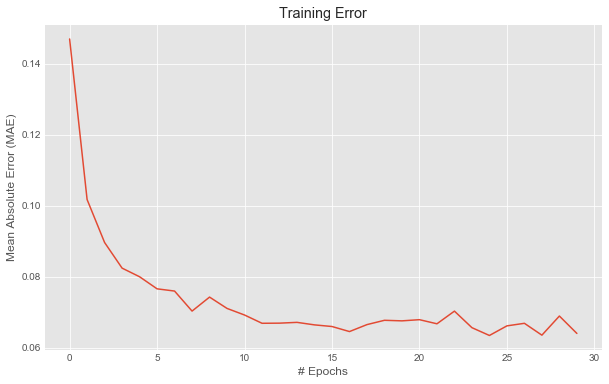

In [102]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.subplots(1,1)

ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')

if eth_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

Kiểm tra model trên dữ liệu test:

In [155]:
actualprice = test_set['eth_Close'][window_len:]
predictedvalue = eth_model.predict(LSTM_test_inputs)
predictedprice = ((np.transpose(predictedvalue) + 1) * test_set['eth_Close'].values[:-window_len])[0]

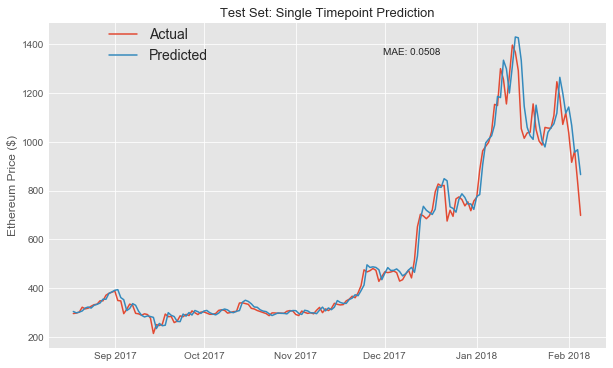

In [247]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.subplots(1,1)
ax1.set_xticks([datetime.date(i,j+1,1) for i in range(2017,2019) for j in range(12)])
ax1.set_xticklabels([datetime.date(i,j+1,1).strftime('%b %Y')  for i in range(2017,2019) for j in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         actualprice, label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         predictedprice, label='Predicted')

ax1.annotate('MAE: %.4f'%mean_absolute_error(predictedvalue, LSTM_test_outputs), 
             xy=(0.6, 0.9),  xycoords='axes fraction',
            xytext=(0.6, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

Như vậy chúng ta đã có model để predict giá của ngày tiếp theo. 

Chúng ta sẽ tiếp tục tạo model khác để dự đoán giá của 5 ngày tiếp theo

In [248]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 5
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['eth_Close'])-pred_range):
    LSTM_training_outputs.append((training_set['eth_Close'][i:i+pred_range].values/
                                  training_set['eth_Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)

In [251]:
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
26s - loss: 0.1981
Epoch 2/50
19s - loss: 0.1433
Epoch 3/50
23s - loss: 0.1300
Epoch 4/50
20s - loss: 0.1240
Epoch 5/50
23s - loss: 0.1186
Epoch 6/50
19s - loss: 0.1232
Epoch 7/50
18s - loss: 0.1155
Epoch 8/50
19s - loss: 0.1196
Epoch 9/50
24s - loss: 0.1141
Epoch 10/50
22s - loss: 0.1150
Epoch 11/50
21s - loss: 0.1168
Epoch 12/50
20s - loss: 0.1114
Epoch 13/50
20s - loss: 0.1123
Epoch 14/50
19s - loss: 0.1122
Epoch 15/50
24s - loss: 0.1144
Epoch 16/50
26s - loss: 0.1124
Epoch 17/50
20s - loss: 0.1117
Epoch 18/50
21s - loss: 0.1116
Epoch 19/50
23s - loss: 0.1117
Epoch 20/50
22s - loss: 0.1117
Epoch 21/50
22s - loss: 0.1097
Epoch 22/50
21s - loss: 0.1109
Epoch 23/50
21s - loss: 0.1091
Epoch 24/50
21s - loss: 0.1084
Epoch 25/50
22s - loss: 0.1101
Epoch 26/50
23s - loss: 0.1065
Epoch 27/50
23s - loss: 0.1085
Epoch 28/50
21s - loss: 0.1068
Epoch 29/50
21s - loss: 0.1087
Epoch 30/50
19s - loss: 0.1073
Epoch 31/50
21s - loss: 0.1100
Epoch 32/50
20s - loss: 0.1103
Epoch 33/50
19s -

In [252]:
eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['eth_Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

In [256]:
eth_pred_prices[-1]

array([ 1223.2613169 ,  1230.86674256,  1257.66557457,  1244.27669297,
        1236.09263254])

In [258]:
testvalue = eth_model.predict(LSTM_test_inputs)

In [267]:
eth_pred_prices[33]

array([ 1223.2613169 ,  1230.86674256,  1257.66557457,  1244.27669297,
        1236.09263254])